In [5]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home-2/gsatopo1@jhu.edu/library/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle as rect
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches

grey='#324356'
turquoise='#54858a'
#aqua='#5ca191'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [grey,turquoise,yellow,yellow_orange,orange])

palette=['#1a4b6e', '#d4a95b', '#b3592e', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

In [3]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)


def lim_params(CO_model):
    cosmo_fid = dict(cosmo_input_camb={'H0':67.36,'ombh2':0.02237,'omch2':0.12,
                      'As':2.1e-9,'ns':0.9649,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100
    nu=115.271*u.GHz
    
    zObs=3
    Dz=1
    if CO_model=='COMAP':
        nuObs,Dnu=Dnu_from_Dz(nu,zObs,Dz)
        model_params = dict(nu=115.271*u.GHz, nuObs=nuObs,
                            sigma_scatter=0.42,
                            hmf_model='ST',
                            bias_model='ST99',
                            model_type='ML',
                            Mmin = 1e10*u.Msun, Mmax=1e15*u.Msun,
                            model_par={'A':-2.85,'B':-0.42,'C':10**10.63,'Ms':10**12.3*u.Msun},
                            model_name='COMAP_Fid',
                            do_onehalo=True, do_RSD=True, smooth=True,
                            kmin=1e-5*u.Mpc**-1, kmax=100*u.Mpc**-1,
                            nk=500, nmu=50, nM=1000,
                            Tmin_VID=0.00001*u.uK,Tmax_VID=100*u.uK,nT=2**21,
                            Lmin=1e-2*u.Lsun,Lmax=1e10*u.Lsun,Ngal_max=30,
                           dndL_Lcut=20*u.Lsun)
        obs_params = dict(Delta_nu=Dnu, dnu=31.25*u.MHz,
                          Tsys_NEFD=45*u.K/(69.4)**0.5, #We get the improvement here as an efficient way
                          Nfeeds=19*2,
                          beam_FWHM=4.5*u.arcmin,
                          tobs=1000*u.hr,
                          Omega_field=4*u.deg**2,
                          Nfield=1)
    elif CO_model=='Li2016':
        nuObs,Dnu=Dnu_from_Dz(nu,zObs,Dz)
        model_params = dict(nu=115.271*u.GHz, nuObs=nuObs,
                            sigma_scatter=0.3,
                            hmf_model='ST',
                            bias_model='ST99',
                            model_type='ML',
                            Mmin = 1e10*u.Msun, Mmax=1e15*u.Msun,
                            model_par={'alpha':1.37, 'beta':-1.74, 'dMF':1.0,'SFR_file':'/home-2/gsatopo1@jhu.edu/library/lim/SFR_tables/UM_sfr.dat','sig_SFR':0.3},
                            model_name='TonyLi',
                            do_onehalo=True, do_RSD=True, smooth=True,
                            kmin=1e-5*u.Mpc**-1, kmax=100*u.Mpc**-1,
                            nk=500, nmu=1000, nM=1000,
                            Tmin_VID=0.00001*u.uK,Tmax_VID=100*u.uK,nT=2**21,
                            Lmin=1e-2*u.Lsun,Lmax=1e10*u.Lsun,Ngal_max=30,
                           dndL_Lcut=20*u.Lsun)
        obs_params = dict(Delta_nu=Dnu, dnu=15.6*u.MHz,
                          Tsys_NEFD=40*u.K, #We get the improvement here as an efficient way
                          Nfeeds=95,
                          beam_FWHM=4*u.arcmin,
                          tobs=9000*u.hr,
                          Omega_field=2.25*u.deg**2,
                          Nfield=4)
        
    obs_params.update(model_params)
    obs_params.update(cosmo_fid)
    return obs_params

In [8]:
m_Li2016=lim(lim_params('Li2016'))
m_COMAP=lim(lim_params('COMAP'))

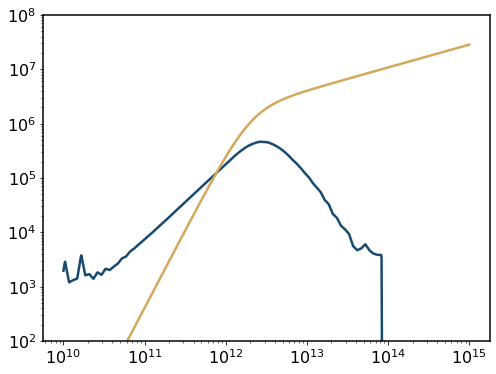

In [84]:
plt.loglog(m_Li2016.M, m_Li2016.LofM)
plt.loglog(m_COMAP.M, m_COMAP.LofM)
plt.ylim(1e2, 1e8)
plt.show()

In [6]:
def LC_params():
    h=0.678
    nu_CO=115.271*u.GHz
    zmin_CO = 2;zmax_CO = 2.8
    zmid_CO=(zmax_CO+zmin_CO)/2
    R=700
    dnu=nu_CO/(1+zmid_CO)/R
    model_params=dict(halo_lightcone_dir='/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/', 
                      lines=dict(CO_J10=True), target_line = 'CO_J10',
                      models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                              model_pars={'alpha':0.67403184,'beta':4.89800039,'alpha_std':0,'beta_std':0,'sigma_L':0})),
                      LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, std_log10Ms_IRX=0.17, std_alpha_IRX=0.17,
                                      K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      supersample=1,
                      Nmu=20,
                      dk=0.02*u.Mpc**-1,
                      do_intensity=False,
                      seed=0)
    obs_params=dict(zmin = zmin_CO-0.03, zmax = zmax_CO+0.03,
                    RAObs_min=-5*u.deg,RAObs_max=5*u.deg,
                    DECObs_min=-5*u.deg,DECObs_max=5*u.deg,
                    RA_min=-5*u.deg,RA_max=5*u.deg,
                    DEC_min=-5*u.deg,DEC_max=5*u.deg,
                    nuObs_max=nu_CO/(1+zmin_CO), nuObs_min=nu_CO/(1+zmax_CO),
                    dnu=dnu,
                    Tsys=0*u.Jy/u.sr,
                    #Tsys=0*u.K,
                    #Tsys=(45*u.K/(69.4)**0.5)*np.sqrt(4/400),
                    Nfeeds=19*2,
                    beam_FWHM=2*u.arcmin,
                    tobs=1000*u.hr,
                    do_angular_smooth=False)
    obs_params.update(model_params)

    return obs_params

In [7]:
LC_CO=make_measurements(LC_params())

In [8]:
inds_RA = (LC_CO.halo_catalog['RA'] > LC_CO.RAObs_min.value)&(LC_CO.halo_catalog['RA'] < LC_CO.RAObs_max.value)
inds_DEC = (LC_CO.halo_catalog['DEC'] > LC_CO.DECObs_min.value)&(LC_CO.halo_catalog['DEC'] < LC_CO.DECObs_max.value)
inds_sky = inds_RA&inds_DEC
inds_redshift=(LC_CO.nuObs_line_halo['CO_J10'] >= LC_CO.nuObs_min)&(LC_CO.nuObs_line_halo['CO_J10'] <= LC_CO.nuObs_max)
inds_SFR=(LC_CO.halo_catalog['SFR_HALO']>0)

inds = inds_SFR&inds_redshift&inds_sky

SM=LC_CO.halo_catalog['SM_HALO'][inds]
SFR=LC_CO.halo_catalog['SFR_HALO'][inds]

log10Ms_IRX,alpha_IRX=9.15, 0.97
sigma_IRX=0.2
K_IR, K_UV=0.63*1.73e-10, 0.63*2.5e-10

IRX = (SM/10**log10Ms_IRX)**alpha_IRX
sigma_base_e = sigma_IRX*2.302585
rng=np.random.default_rng(0)
IRX = IRX*rng.lognormal(-0.5*sigma_base_e**2, sigma_base_e, IRX.shape)

LIR = SFR/(K_IR + K_UV/IRX)*u.Lsun
logM=np.log10(LC_CO.halo_catalog['M_HALO'][inds]*LC_CO.Msunh.to(u.Msun).value)

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_143.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_144.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_145.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_146.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_147.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_148.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_149.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_150.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_151.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_152.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_153.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_154.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

#### Compare the $L_{\rm IR}$ from Kennicut 1998 with our new implementation

Li et al 2016 assumes he relation between $L_{\rm IR}$ and SFR presented in Kennicut 1998, which is given by
\begin{equation}
{\rm SFR} = \delta_{MF} \times 10^{-10} L_{\rm IR}.
\end{equation}

We adopt in our work the following relation 
\begin{equation}
    L_{\rm IR} = \frac{\text{SFR}}{K_{\rm IR} + K_{\rm UV}{\rm IRX}^{-1}},
\end{equation}
where
\begin{equation}
    \text{IRX} = \left(\frac{M}{M_*}\right)^{\alpha}.
\end{equation}

We compare the two below

In [44]:
logM_bin=np.linspace(10.5, 13.5, 41)
meanLIR=[]
meanLIR_old=[]
meanSFR=[]
for i in range(len(logM_bin)-1):
    inds_M = (logM>=logM_bin[i])&(logM<logM_bin[i+1])
    Lbin_IR = LIR[inds_M]
    Lbin_IRold = 1e10 * SFR[inds_M]/1

    SFRbin = SFR[inds_M]
    meanLIR.append(np.mean(Lbin_IR).value)
    meanLIR_old.append(np.mean(Lbin_IRold))
    meanSFR.append(np.mean(SFRbin))

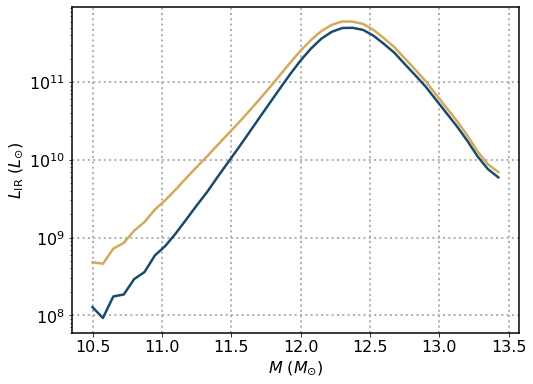

In [45]:
plt.plot(logM_bin[:-1], meanLIR)
plt.plot(logM_bin[:-1], meanLIR_old)
plt.ylabel(r'$L_{\rm IR}$ ($L_{\odot}$)')
plt.xlabel(r'$M$ $(M_{\odot})$')
plt.yscale('log')
plt.grid(linestyle='dotted', linewidth=2)

In [3]:
def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor='r',
                     edgecolor='None', alpha=0.5):

    # Loop over data points; create box from errors at each point
    errorboxes = [rect((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
                  for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T)]

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor, lw=1.5)

    # Add collection to axes
    artists = ax.add_collection(pc)
    ax.plot(0,0)

    return artists

### Fit to COLDz data

The full data provided by COLDz includes several overlapping bins in luminosity. We consider only the independent, non-overlapping ones in our fit.

In [11]:
#total data for the shaded boxes plot
logLCOdat = np.arange(9.5,11.01,0.1)+0.25
LCOwidth = np.ones((2,len(logLCOdat)))*0.25
logphi_max = np.array([-2.21,-2.69,-2.95,-3.12,-3.24,-3.32,-3.41,-3.37,-3.39,-3.45,-3.60,-3.70,-4.11,-4.25,-4.41,-4.45])
logphi_min = np.array([-4.04,-4.08,-4.14,-4.19,-4.23,-4.10,-4.07,-3.76,-3.69,-3.73,-3.98,-4.10,-4.79,-5.00,-5.44,-6.28])
logphidat = 0.5*(logphi_max+logphi_min)
logphiwidth = np.ones((2,len(logLCOdat)))*0.5*(logphi_max-logphi_min)

#independent data used for the fit
xdata = np.arange(9.5,11.01,0.5)+0.25
ydata_max = np.array([-2.21,-3.32,-3.60,-4.45])
ydata_min = np.array([-4.04,-4.10,-3.98,-6.28])
ydata = 0.5*(ydata_max+ydata_min)
ydata_err = np.ones((len(xdata)))*0.5*(ydata_max-ydata_min)

#xdata = np.arange(9.5,11.01,0.1)+0.25
#ydata_max = np.array([-2.21,-2.69,-2.95,-3.12,-3.24,-3.32,-3.41,-3.37,-3.39,-3.45,-3.60,-3.70,-4.11,-4.25,-4.41,-4.45])
#ydata_min = np.array([-4.04,-4.08,-4.14,-4.19,-4.23,-4.10,-4.07,-3.76,-3.69,-3.73,-3.98,-4.10,-4.79,-5.00,-5.44,-6.28])
#ydata = 0.5*(ydata_max+ydata_min)
#ydata_err = np.ones((len(xdata)))*0.5*(ydata_max-ydata_min)

In [13]:
#compute the histogram from our LC - will be used as the function to be fit
def logphi_Lp(logL,a,b):
    #print(a,b)
    dlogL=np.asarray([-0.25, +0.25])
    logLp=(np.log10(LIR.value)-b)/a
    logLp_bin=logL[:, None]*np.ones((len(logL),2)) + dlogL[None,:]*np.ones((len(logL),1))

    Nhalos=np.asarray([np.sum((logLp>logLp_bin[i,0])&(logLp<=logLp_bin[i,1])) for i in range(len(logL))])
    phi=Nhalos/0.5/((LC_CO.Lbox[0]*LC_CO.Lbox[1]*LC_CO.Lbox[2]).to(u.Mpc**3))
    #phi=interp1d(x, y.value)
    logphi=np.log10(phi.value)
    return logphi

We plot here the initial parameters given to curve_fit and will test the convergence in the following cell

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, '$\\log \\phi_{\\rm CO}$')

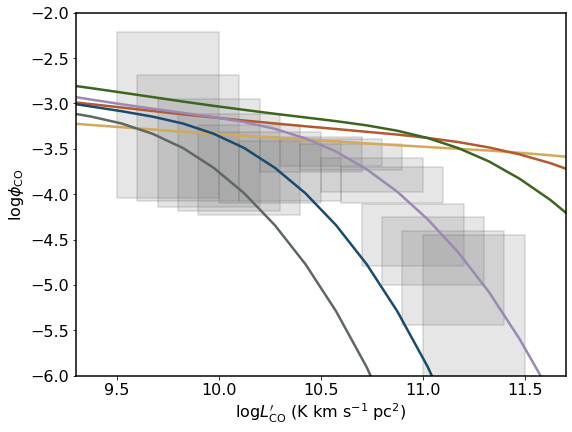

In [14]:
p0=np.asarray([[0.4, 7], [0.6, 5], [0.8, 3], [0.9, 2.5], [1, 2.2], [1, 1.9]])
logLp_bin=np.linspace(9, 12, 21)
logLp_center=logLp_bin[:-1]+np.diff(logLp_bin)[0]/2

gs = gridspec.GridSpec(1, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0)
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(gs[0,0])
_ = make_error_boxes(ax,logLCOdat,logphidat,LCOwidth,logphiwidth,alpha=0.2, facecolor='#828282', edgecolor='#575757')
for i in range(len(p0)):
    ax.plot(logLp_center, logphi_Lp(logLp_center,p0[i,0], p0[i,1]))
    
plt.ylim(-6,-2)
plt.xlim(9.3,11.7)
plt.xlabel(r'$\log L^{\prime}_{\rm CO}$ (K km s$^{-1}$ pc$^2$)')
plt.ylabel(r'$\log \phi_{\rm CO}$')

Fit for different values of epsfcn and initial parameters

In [15]:
p0=np.asarray([[0.4, 7], [0.6, 5], [0.8, 3], [0.9, 2.5], [1, 2.2], [1, 1.9]])
epsfcn=np.asarray([1e-4, 1e-5, 1e-6])
res=np.zeros((len(epsfcn), len(p0), 2))

for i in range(len(epsfcn)):
    for j in range(len(p0)):
        popt, pcov = curve_fit(logphi_Lp, xdata, ydata, p0=[p0[j,0],p0[j,1]], sigma=ydata_err/2,
                               check_finite=True,
                               method='lm',
                               maxfev=1000,
                               epsfcn=epsfcn[i])
        print(epsfcn[i], popt)
        print(pcov)
        res[i,j]=popt

0.0001 [0.77527007 3.85469421]
[[ 0.07409369 -0.8030539 ]
 [-0.8030539   8.70936098]]


/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


0.0001 [0.64660329 5.19344502]
[[ 0.09957721 -1.04995276]
 [-1.04995276 11.07708329]]
0.0001 [0.78647298 3.73933199]
[[ 0.06862774 -0.74716383]
 [-0.74716383  8.14010344]]
0.0001 [0.75981663 4.01696485]
[[ 0.05109476 -0.5526022 ]
 [-0.5526022   5.98211703]]


/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.0001 [1.  2.2]
[[inf inf]
 [inf inf]]
0.0001 [0.76298955 3.98448066]
[[ 0.07193018 -0.78062443]
 [-0.78062443  8.47737416]]
1e-05 [0.61308465 5.54154663]
[[ 0.0899053  -0.93539239]
 [-0.93539239  9.73916435]]
1e-05 [0.70358613 4.60383161]
[[ 0.18562385 -1.93845398]
 [-1.93845398 20.24917954]]
1e-05 [0.80709748 3.52376565]
[[ 0.05050266 -0.53776867]
 [-0.53776867  5.73208551]]
1e-05 [0.98848314 1.62180996]
[[ 0.03600122 -0.38020898]
 [-0.38020898  4.02195031]]
1e-05 [1.  2.2]
[[inf inf]
 [inf inf]]
1e-05 [0.85925387 2.97567075]
[[ 0.03089074 -0.32698887]
 [-0.32698887  3.46704941]]
1e-06 [0.75032861 4.11838378]
[[ 0.0297798  -0.30596438]
 [-0.30596438  3.14884004]]
1e-06 [0.74078922 4.21486069]
[[ 0.02444275 -0.25981142]
 [-0.25981142  2.76756048]]
1e-06 [0.80631665 3.53075861]
[[ 0.0478696  -0.48487087]
 [-0.48487087  4.91633727]]
1e-06 [0.82480489 3.33530058]
[[ 0.0075847  -0.07809554]
 [-0.07809554  0.80954931]]
1e-06 [1.  2.2]
[[inf inf]
 [inf inf]]
1e-06 [0.95256049 1.99911107]
[

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, '$\\log \\phi_{\\rm CO}$')

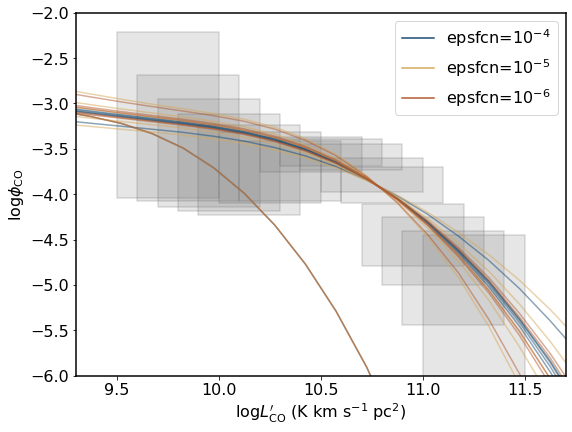

In [17]:
from matplotlib.lines import Line2D

logLp_bin=np.linspace(9, 12, 21)
logLp_center=logLp_bin[:-1]+np.diff(logLp_bin)[0]/2

gs = gridspec.GridSpec(1, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0)
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(gs[0,0])
_ = make_error_boxes(ax,logLCOdat,logphidat,LCOwidth,logphiwidth,alpha=0.2, facecolor='#828282', edgecolor='#575757')
for i in range(len(p0)):
    ax.plot(logLp_center, logphi_Lp(logLp_center,res[0,i,0], res[0,i,1]), color=palette[0], lw=1.5, alpha=0.5, label=r'epsfcn=$10^{-4}$')
for i in range(len(p0)):
    ax.plot(logLp_center, logphi_Lp(logLp_center,res[1,i,0], res[1,i,1]), color=palette[1], lw=1.5, alpha=0.5, label=r'epsfcn=$10^{-5}$')
for i in range(len(p0)):
    ax.plot(logLp_center, logphi_Lp(logLp_center,res[2,i,0], res[2,i,1]), color=palette[2], lw=1.5, alpha=0.5, label=r'epsfcn=$10^{-6}$')

custom_lines = [Line2D([0], [0], color=palette[0], lw=1.5),
                Line2D([0], [0], color=palette[1], lw=1.5),
                Line2D([0], [0], color=palette[2], lw=1.5)]
ax.legend(custom_lines, [r'epsfcn=$10^{-4}$', r'epsfcn=$10^{-5}$', r'epsfcn=$10^{-6}$'])

plt.ylim(-6,-2)
plt.xlim(9.3,11.7)
plt.xlabel(r'$\log L^{\prime}_{\rm CO}$ (K km s$^{-1}$ pc$^2$)')
plt.ylabel(r'$\log \phi_{\rm CO}$')

In [10]:
def chi_squared(da, db, cov):
    sig_a=np.sqrt(cov[0,0])
    sig_b=np.sqrt(cov[1,1])
    corr=cov[0,1]/sig_a/sig_b
    
    chi_sq=((da/sig_a)**2 + (db/sig_b)**2 - 2*corr*(da/sig_a)*(db/sig_b))/(1-corr**2)
    return chi_sq

In [31]:
from numpy.random import normal,multivariate_normal

alpha_fid, beta_fid=0.67403184,4.89800039
pcov=np.asarray([[0.0610079,-0.6413858],[-0.6413858,6.74931735]])

alphas, betas = multivariate_normal(np.array([alpha_fid,beta_fid]),pcov,100).T

logLp_bin=np.linspace(9, 12, 21)
logLp_center=logLp_bin[:-1]+np.diff(logLp_bin)[0]/2

phi_fit=logphi_Lp(logLp_center,alpha_fid, beta_fid)

logphi_1sig=[]
for i in range(len(alphas)):
    chi=chi_squared(alphas[i]-alpha_fid, betas[i]-beta_fid, pcov)
    print(alphas[i], betas[i], chi)
    if chi<=2.3:
        logphi_1sig.append(logphi_Lp(logLp_center,alphas[i], betas[i]))

0.9425046745231669 2.171140286515229 2.6273266157121555
0.9957371437435304 1.4818921309587192 1.878814220915681


/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


1.0845748539095208 0.46613906964829166 4.88089066625615
0.6917821613012418 4.746684911223223 0.20210564031737033
1.0434559080718169 0.96658599228364 2.595162098605743
0.488944992342479 6.826526480602558 0.6089488800758537
0.6550044964936343 5.002729658575069 1.441868125567425
0.7501876854614412 4.055432926711549 0.3729725078034344
0.3826126211254002 7.895494403217752 2.0857022299180423
0.3803741094455286 8.034357884294085 1.7943970941934468
0.7695795306228048 3.8675160157217077 0.2563082904909504
0.4292771558588001 7.422227921769371 1.3601908489568542
1.108847665537707 0.3357222242352105 3.1118547138682078
0.6740485316176078 4.928754655933995 0.15122595823889215
0.6255934361599174 5.407151132656121 0.0384598875278234
0.47601018097495185 6.826196715509234 4.37408995622662
0.6899409189624035 4.763567138263809 0.17443847574708196
0.7689588639134687 3.8128747611197458 1.3481299536748972
0.11176004793422611 10.787763842815679 5.255110817978767
0.6929575472960601 4.584287927733614 2.08714670

In [1]:
gs = gridspec.GridSpec(1, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0)
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(gs[0,0])
_ = make_error_boxes(ax,logLCOdat,logphidat,LCOwidth,logphiwidth,alpha=0.2, facecolor='#828282', edgecolor='#575757')
#ax.errorbar(xdata, ydata, yerr=ydata_err, fmt='o', color=grey)

ax.plot(logLp_center,phi_fit, color='#b3524b', label='This work')
ax.plot(logLp_center,np.max(logphi_1sig, axis=0), '--', lw=1, color='#b3524b')
ax.plot(logLp_center,np.min(logphi_1sig, axis=0), '--', lw=1, color='#b3524b')

handles, labels = ax.get_legend_handles_labels()

coldz = mpatches.Patch(color='#828282', edgecolor='#575757', alpha=0.2, label='COLDz')
handles.append(coldz) 
plt.legend(handles=handles)

plt.ylim(-6,-2)
plt.xlim(9.3,11.7)
plt.xlabel(r'$\log L^{\prime}_{\rm CO}$ (K km s$^{-1}$ pc$^2$)')
plt.ylabel(r'$\log \phi_{\rm CO}$')
#plt.savefig('../../Lf_CO.png', dpi=300)

NameError: name 'gridspec' is not defined

In [ ]:
[0.75536207 4.05012118]
[[ 0.0827788  -0.88474465]
 [-0.88474465  9.46197633]]

In [ ]:
[0.67717715 4.86329354]
[[ 0.0610079  -0.6413858 ]
 [-0.6413858   6.74931735]]

In [ ]:
[0.67403184 4.89800039]
[[ 0.06303848 -0.66300452]
 [-0.66300452  6.97952166]]

In [4]:
nu_CO=115.271*u.GHz

LC_CO.update(RAObs_min=-10*u.deg,RAObs_max=10*u.deg,DECObs_min=-10*u.deg,DECObs_max=10*u.deg,
             RA_min=-10*u.deg,RA_max=10*u.deg,DEC_min=-10*u.deg,DEC_max=10*u.deg,
             zmin = 2.5-0.03, zmax = 3.5+0.03,
             nuObs_max=nu_CO/(1+2.5), nuObs_min=nu_CO/(1+3.5),
             models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                     model_pars={'alpha':0.67403184,'beta':4.89800039,'alpha_std':0,'beta_std':0,'sigma_L':0})),
             LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, std_log10Ms_IRX=0.17, std_alpha_IRX=0.17,
                             K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10))

In [5]:
inds_RA = (LC_CO.halo_catalog['RA'] > LC_CO.RAObs_min.value)&(LC_CO.halo_catalog['RA'] < LC_CO.RAObs_max.value)
inds_DEC = (LC_CO.halo_catalog['DEC'] > LC_CO.DECObs_min.value)&(LC_CO.halo_catalog['DEC'] < LC_CO.DECObs_max.value)
inds_sky = inds_RA&inds_DEC

inds = (LC_CO.nuObs_line_halo['CO_J10'] >= LC_CO.nuObs_min)&(LC_CO.nuObs_line_halo['CO_J10'] <= LC_CO.nuObs_max)&inds_sky
M_in_survey = LC_CO.halo_catalog['M_HALO'][inds]*LC_CO.Msunh.to(u.Msun).value

logMcat_CO=np.log10(M_in_survey)
LCO = LC_CO.halos_in_survey['CO_J10']['Lhalo'].value
logM=np.linspace(np.min(logMcat_CO), np.max(logMcat_CO), 50)

meanLCO=[]
for i in range(len(logM)-1):
    inds = (logMcat_CO>=logM[i])&(logMcat_CO<logM[i+1])&(LCO>0)
    Lbin = LCO[inds]
    meanLCO.append(np.mean(Lbin))

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
LC_CO.update(models=dict(CO_J10=dict(model_name='CO_Li16',
                                     model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})))

In [11]:
inds_RA = (LC_CO.halo_catalog['RA'] > LC_CO.RAObs_min.value)&(LC_CO.halo_catalog['RA'] < LC_CO.RAObs_max.value)
inds_DEC = (LC_CO.halo_catalog['DEC'] > LC_CO.DECObs_min.value)&(LC_CO.halo_catalog['DEC'] < LC_CO.DECObs_max.value)
inds_sky = inds_RA&inds_DEC

inds = (LC_CO.nuObs_line_halo['CO_J10'] >= LC_CO.nuObs_min)&(LC_CO.nuObs_line_halo['CO_J10'] <= LC_CO.nuObs_max)&inds_sky
M_in_survey = LC_CO.halo_catalog['M_HALO'][inds]*LC_CO.Msunh.to(u.Msun).value

logMcat_CO_Li2016=np.log10(M_in_survey)
LCO_Li2016 = LC_CO.halos_in_survey['CO_J10']['Lhalo'].value
logM=np.linspace(np.min(logMcat_CO), np.max(logMcat_CO), 50)

meanLCO_Li2016=[]
for i in range(len(logM)-1):
    inds = (logMcat_CO_Li2016>=logM[i])&(logMcat_CO_Li2016<logM[i+1])&(LCO_Li2016>0)
    Lbin = LCO_Li2016[inds]
    meanLCO_Li2016.append(np.mean(Lbin))

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


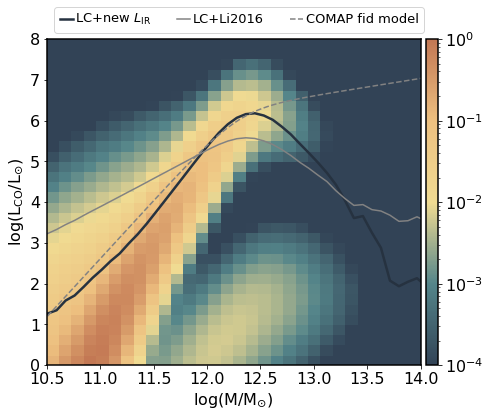

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
im=ax.hist2d(logMcat_CO[LCO>0], np.log10(LCO[LCO>0]), bins=[np.linspace(10.5, 14, 31), np.linspace(0, 7.5, 31)], 
          norm=mpl.colors.LogNorm(), 
          cmap=cmap, density=True, 
          vmin=1e-4, vmax=1)
ax.plot(logM[:-1], np.log10(meanLCO), color='#263240', label=r'LC+new $L_{\rm IR}$')
ax.plot(logM[:-1], np.log10(meanLCO_Li2016), color='#828282', lw=1.5, label=r'LC+Li2016')
ax.plot(np.log10(m_COMAP.M.value), np.log10(m_COMAP.LofM.value), '--', color='#828282', lw=1.5, label=r'COMAP fid model')

ax.set_facecolor(grey)
ax.set_ylim(0, 8)
ax.set_xlim(10.5, 14)
ax.set_ylabel(r'$\log$(L$_{\rm CO}$/L$_{\odot}$)')
ax.set_xlabel(r'$\log$(M/M$_{\odot}$)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.08)
fig.colorbar(im[3], cax=cax, orientation='vertical')
ax.legend(ncol=3, loc=(0.02,1.02), fontsize=13, handletextpad=0.2, handlelength=1)
plt.savefig('../../LofM.png', dpi=300)

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


Text(0.5, 0, '$\\log$(M/M$_{\\odot}$)')

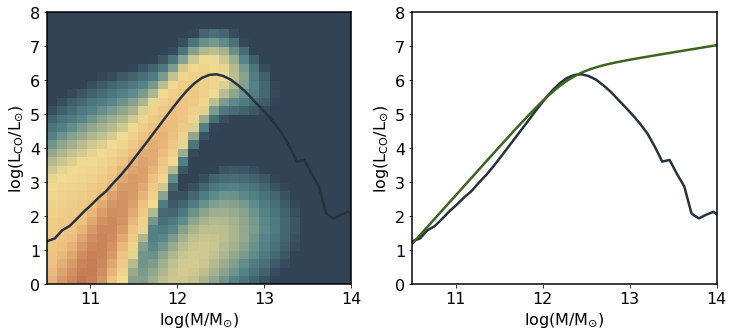

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax[0].hist2d(logMcat_CO[LCO>0], np.log10(LCO[LCO>0]), bins=[np.linspace(10.5, 14, 31), np.linspace(0, 7.5, 31)], 
          norm=mpl.colors.LogNorm(), 
          cmap=cmap, density=True, 
          vmin=1e-4, vmax=1)
ax[0].plot(logM[:-1], np.log10(meanLCO), color='#263240')
ax[0].set_facecolor(grey)
ax[0].set_ylim(0, 8)
ax[0].set_xlim(10.5, 14)
ax[0].set_ylabel(r'$\log$(L$_{\rm CO}$/L$_{\odot}$)')
ax[0].set_xlabel(r'$\log$(M/M$_{\odot}$)')

ax[1].plot(logM[:-1], np.log10(meanLCO), color='#263240')
ax[1].plot(np.log10(m_COMAP.M.value), np.log10(m_COMAP.LofM.value), color=palette[3])
ax[1].set_ylim(0, 8)
ax[1].set_xlim(10.5, 14)
ax[1].set_ylabel(r'$\log$(L$_{\rm CO}$/L$_{\odot}$)')
ax[1].set_xlabel(r'$\log$(M/M$_{\odot}$)')

In [60]:
nu_CO=115.271*u.GHz

LC_CO.update(RAObs_min=-10*u.deg,RAObs_max=10*u.deg,DECObs_min=-10*u.deg,DECObs_max=10*u.deg,
             RA_min=-10*u.deg,RA_max=10*u.deg,DEC_min=-10*u.deg,DEC_max=10*u.deg,
             zmin = 2.3-0.03, zmax = 3.3+0.03,
             nuObs_max=nu_CO/(1+2.3), nuObs_min=nu_CO/(1+3.3))

In [89]:
k_IR=LC_CO.k_Pk_poles
Pk_IR=LC_CO.Pk_0

In [91]:
LC_CO.update(models=dict(CO_J10=dict(model_name='CO_Li16',
                                     model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})))

In [92]:
k_Li2016=LC_CO.k_Pk_poles
Pk_Li2016=LC_CO.Pk_0

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


NameError: name 'k_IR' is not defined

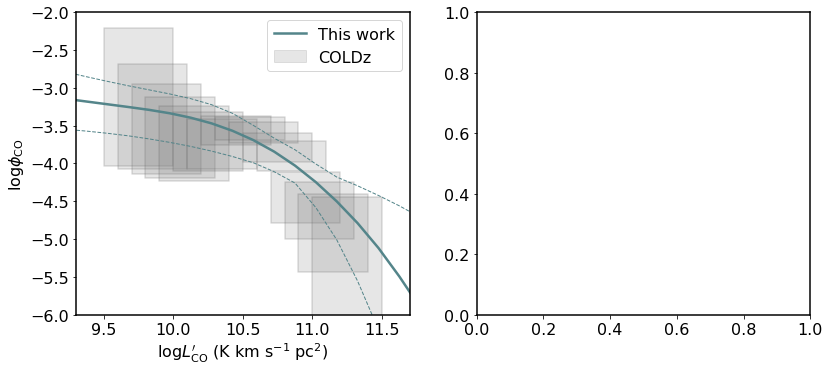

In [32]:
color=turquoise

gs = gridspec.GridSpec(1, 2,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.2,hspace=.0)
fig = plt.figure(figsize=(12,5))
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

_ = make_error_boxes(ax0,logLCOdat,logphidat,LCOwidth,logphiwidth,alpha=0.2, facecolor='#828282', edgecolor='#575757')
#ax.errorbar(xdata, ydata, yerr=ydata_err, fmt='o', color=grey)

ax0.plot(logLp_center,phi_fit, color=color, label='This work')
ax0.plot(logLp_center,np.max(logphi_1sig, axis=0), '--', lw=1, color=color)
ax0.plot(logLp_center,np.min(logphi_1sig, axis=0), '--', lw=1, color=color)

handles, labels = ax0.get_legend_handles_labels()

coldz = mpatches.Patch(color='#828282', edgecolor='#575757', alpha=0.2, label='COLDz')
handles.append(coldz) 
ax0.legend(handles=handles)

ax0.set_ylim(-6,-2)
ax0.set_xlim(9.3,11.7)
ax0.set_xlabel(r'$\log L^{\prime}_{\rm CO}$ (K km s$^{-1}$ pc$^2$)')
ax0.set_ylabel(r'$\log \phi_{\rm CO}$')


ax1.loglog(k_IR, Pk_IR, color=color, label=r'LC+new $L_{\rm IR}$')
ax1.loglog(k_Li2016, Pk_Li2016, '--', color=color, label='LC+Li2016')
ax1.errorbar(1, 2e3, xerr=np.array([[0.5,1]]).T, yerr=np.array([[1.2e3,1.1e3]]).T, 
             fmt='o', color='#828282', label='COPSS')
ax1.set_xlabel(r'k [$h\ Mpc^{-1}$]')
ax1.set_ylabel(r'P(k) [$\mu K^2\ h^{-3}\ Mpc^3$]')
ax1.set_xlim(0.05, 2.2)
ax1.legend(loc='lower left')
#plt.savefig('../../Lf_Pk_CO.png', dpi=300)

In [69]:
(2-0.5)/2

0.75